# Inference and Validation 

v2
- to evaluate validation score 
- evaluate Top-view image 

In [1]:
#--
import sys
sys.path.append("/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/07.Challenge/01.MapYourCity_HuggingFace")
import map_dataset
import map_train
from models import *

sys.path.append("/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/00.Libs")
import RS_dataset
import RS_models
import RS_utils
#--- torch
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
#--- loss functions
from utils.losses import LabelSmoothCrossEntropy, CrossEntropyLoss
from torch.cuda.amp import GradScaler, autocast
#---
from lightning.fabric import Fabric
from lightning.fabric.loggers import CSVLogger, TensorBoardLogger
from torchmetrics.classification import Accuracy
import pandas as pd 
import os 
from sklearn.model_selection import train_test_split
import argparse
import yaml 
import timm
import numpy as np 
import time
import wandb
from rich.console import Console

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.10 (you have 1.4.8). Upgrade using: pip install --upgrade albumentations
/mnt/hdd/eric/.conda/envs/mapv2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#--- argparser
parser = argparse.ArgumentParser()
parser.add_argument('--cfg', type=str, default='./configs/finetune_8.yaml')
ckpt_path = "/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/07.Challenge/01.MapYourCity_HuggingFace/output/18_eva02_base_patch14_448.mim_in22k_ft_in22k_in1k_f1_0.7226_epoch_5.pth"

args = parser.parse_args(args=[])
cfg = argparse.Namespace(**yaml.load(open(args.cfg), Loader=yaml.SafeLoader))

In [3]:
#--- Data 
input_path = "/mnt/hdd/eric/.tmp_ipy/00.Data/Map_Your_City/building-age-dataset/"
train_path = input_path + "train/data/"
test_path = input_path + "test/data/"
train_df = pd.read_csv(input_path + "train/train-set.csv")
test_df = pd.read_csv(input_path + "test/test-set.csv") 

#--- data split 
names_data = os.listdir(train_path)
names_train, names_valid = train_test_split(names_data, test_size=0.1, random_state=1)

In [4]:
if cfg.TIMM: 
    model = timm.create_model(
    cfg.MODEL,
    pretrained=True,
    num_classes=cfg.CLASSES_NUM )
    
    #--- data config and transform
    data_config = timm.data.resolve_model_data_config(model)
    data_transform = timm.data.create_transform(**data_config, is_training=False)

    #logger.info(data_config)
    #logger.info(data_transform)

print("#--- run version : ", cfg.RUN_VERSION)

/mnt/hdd/eric/.conda/envs/mapv2/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k)
INFO:timm.models._hub:[timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


#--- run version :  18


In [5]:
model.load_state_dict(torch.load(ckpt_path))

<All keys matched successfully>

In [6]:
train_set = map_dataset.Map_Dataset_v6(names_train,train_path,max_size=data_config['input_size'][1],cfg=cfg,split="valid") 
valid_set = map_dataset.Map_Dataset_v6(names_valid,train_path,max_size=data_config['input_size'][1],cfg=cfg,split="valid")  

In [7]:
print(train_set.__getitem__(0)[0].shape)
print(train_set.__getitem__(0)[1])

torch.Size([3, 448, 448])
tensor([[[-0.9705, -0.9020, -0.7308,  ..., -1.0562, -1.2445, -1.4500],
         [-1.1247, -0.9705, -0.7308,  ..., -0.9534, -1.1932, -1.4158],
         [-1.1418, -0.8507, -0.7993,  ..., -0.9020, -1.2445, -1.4329],
         ...,
         [ 1.2557,  0.5707,  0.2967,  ..., -0.2171,  0.1426,  0.4679],
         [ 1.3242,  1.0159,  0.5707,  ..., -0.1999, -0.1486,  0.3138],
         [ 1.1872,  1.1529,  0.6734,  ..., -0.1999, -0.2342, -0.1486]],

        [[-0.3901, -0.3200, -0.0749,  ..., -0.4776, -0.7577, -1.0028],
         [-0.6001, -0.4251, -0.1275,  ..., -0.3725, -0.6877, -0.9853],
         [-0.6527, -0.3200, -0.2325,  ..., -0.3025, -0.7402, -0.9853],
         ...,
         [ 1.4482,  0.5728,  0.2052,  ..., -0.0574,  0.2927,  0.6254],
         [ 1.5182,  1.1506,  0.5553,  ..., -0.0399, -0.0399,  0.4328],
         [ 1.3256,  1.3431,  0.7654,  ..., -0.0749, -0.1275, -0.0224]],

        [[-0.3055, -0.2707, -0.1138,  ..., -0.1661, -0.3578, -0.5321],
         [-0.4450, 

Label :  5
Prediction :  tensor([0], device='cuda:3')


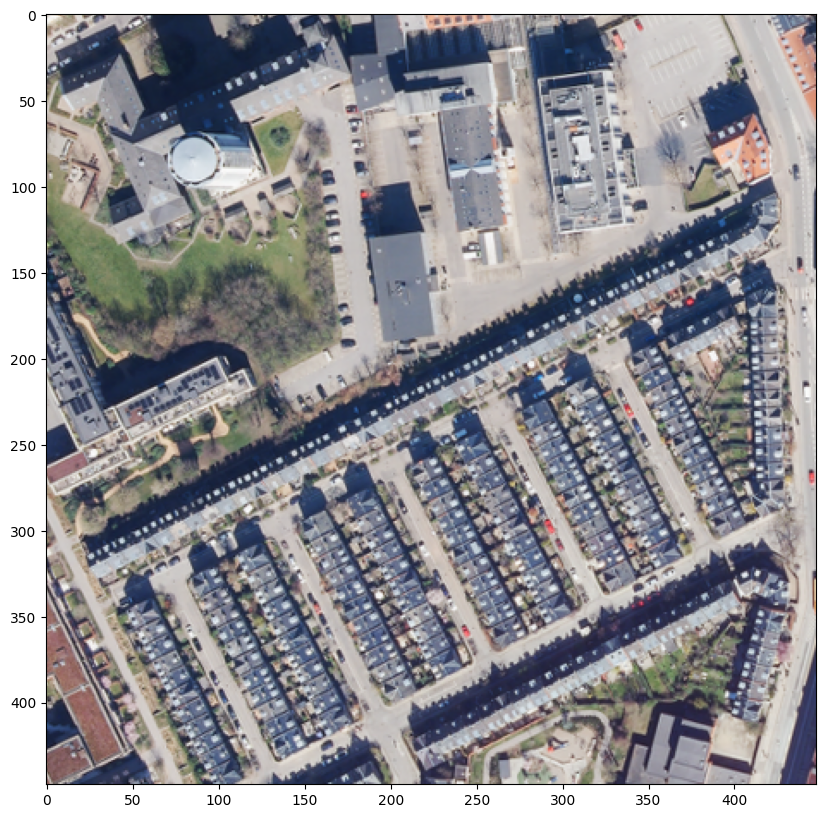

In [8]:
#--- Single image for Visualization 

import random
idx_ = random.randint(0,999)
img_torch = valid_set.__getitem__(idx_)[1]
RS_utils.torch_display(img_torch, False, True)

#--- inference
device = "cuda:3"

model = model.to(device)
img_torch = img_torch.to(device)
model.eval()
img_torch = img_torch.unsqueeze(0)
preds = model(img_torch)
preds = preds.argmax(1)

print("Label : ",train_set.__getitem__(idx_)[2])
print("Prediction : ", preds)

In [9]:
batch_size = 8
TrainLoader = DataLoader(train_set,batch_size)
ValidLoader = DataLoader(valid_set,batch_size,shuffle=False)

In [10]:
'''
CE models 

'''

from tqdm import tqdm


loss_fn = "CE"
device = "cuda:3"
model = model.to(device)

#-- Loader train/valid
Loader = ValidLoader
#--
labels_ = []
predictions_ = []
print("LOSS FN : ", loss_fn)
for batch in tqdm(Loader):
    imgs = batch[1].to(device)
    lables = batch[2]
    batch_preds = model(imgs)
    
    
    if loss_fn == "CE":  
        predictions = torch.argmax(batch_preds,-1).detach().cpu().numpy()
    else:
        predictions = batch_preds.detach().cpu().numpy()
    
    # #-- 
    predictions_.extend(predictions)
    labels_.extend(lables)
    
#-- memory clean 
torch.cuda.empty_cache()

LOSS FN :  CE


  0%|          | 0/386 [00:00<?, ?it/s]

100%|██████████| 386/386 [01:47<00:00,  3.59it/s]


In [11]:
len(labels_)

3085

In [12]:
len(predictions_)

3085

In [13]:
labels_

[tensor(5),
 tensor(2),
 tensor(5),
 tensor(0),
 tensor(0),
 tensor(4),
 tensor(5),
 tensor(3),
 tensor(0),
 tensor(0),
 tensor(6),
 tensor(3),
 tensor(5),
 tensor(2),
 tensor(1),
 tensor(5),
 tensor(5),
 tensor(3),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(4),
 tensor(1),
 tensor(5),
 tensor(3),
 tensor(0),
 tensor(2),
 tensor(4),
 tensor(6),
 tensor(5),
 tensor(4),
 tensor(1),
 tensor(1),
 tensor(0),
 tensor(1),
 tensor(5),
 tensor(0),
 tensor(2),
 tensor(0),
 tensor(0),
 tensor(4),
 tensor(3),
 tensor(0),
 tensor(1),
 tensor(6),
 tensor(1),
 tensor(0),
 tensor(2),
 tensor(3),
 tensor(0),
 tensor(3),
 tensor(3),
 tensor(0),
 tensor(4),
 tensor(3),
 tensor(5),
 tensor(6),
 tensor(1),
 tensor(0),
 tensor(2),
 tensor(1),
 tensor(5),
 tensor(4),
 tensor(5),
 tensor(1),
 tensor(6),
 tensor(6),
 tensor(6),
 tensor(3),
 tensor(1),
 tensor(2),
 tensor(3),
 tensor(6),
 tensor(4),
 tensor(3),
 tensor(3),
 tensor(0),
 tensor(0),
 tensor(6),
 tensor(1),
 tensor(0),
 tensor(0),
 tensor(5),
 ten

In [14]:
predictions_

[5,
 2,
 5,
 2,
 0,
 0,
 1,
 3,
 0,
 5,
 2,
 3,
 5,
 2,
 1,
 5,
 0,
 3,
 4,
 0,
 0,
 4,
 3,
 5,
 3,
 0,
 2,
 4,
 3,
 3,
 4,
 0,
 1,
 0,
 1,
 5,
 0,
 0,
 0,
 0,
 3,
 5,
 0,
 0,
 6,
 1,
 1,
 5,
 3,
 0,
 3,
 3,
 0,
 4,
 3,
 0,
 5,
 1,
 1,
 2,
 1,
 5,
 4,
 5,
 0,
 6,
 5,
 5,
 3,
 1,
 2,
 3,
 0,
 4,
 3,
 3,
 0,
 0,
 5,
 1,
 0,
 0,
 6,
 0,
 4,
 4,
 5,
 2,
 0,
 6,
 5,
 0,
 3,
 3,
 4,
 6,
 6,
 5,
 2,
 4,
 1,
 2,
 3,
 6,
 2,
 0,
 1,
 0,
 4,
 5,
 4,
 3,
 0,
 3,
 0,
 5,
 0,
 0,
 0,
 6,
 0,
 0,
 6,
 5,
 5,
 5,
 2,
 0,
 3,
 3,
 3,
 1,
 2,
 4,
 0,
 6,
 4,
 0,
 4,
 0,
 6,
 0,
 0,
 0,
 4,
 0,
 2,
 3,
 1,
 1,
 0,
 2,
 3,
 0,
 0,
 1,
 0,
 5,
 4,
 2,
 4,
 1,
 2,
 6,
 0,
 4,
 6,
 3,
 4,
 0,
 0,
 5,
 0,
 1,
 6,
 6,
 3,
 0,
 6,
 1,
 0,
 0,
 4,
 0,
 5,
 0,
 0,
 0,
 2,
 0,
 0,
 1,
 0,
 2,
 2,
 3,
 0,
 4,
 5,
 1,
 5,
 0,
 3,
 0,
 0,
 5,
 0,
 4,
 0,
 5,
 5,
 0,
 4,
 0,
 3,
 0,
 3,
 5,
 3,
 3,
 0,
 4,
 4,
 6,
 6,
 5,
 0,
 1,
 3,
 3,
 3,
 3,
 1,
 3,
 0,
 3,
 0,
 0,
 0,
 6,
 1,
 3,
 6,
 2,
 6,
 3,
 1,
 5,
 6,
 0,


In [15]:
# trans_predictions_ = np.trunc(predictions_)

In [16]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

precision, recall, f1, _ = precision_recall_fscore_support(labels_, predictions_, average='weighted')
accuracy = accuracy_score(labels_, predictions_)

print(precision, recall, f1,accuracy)

0.6905718791977338 0.6904376012965965 0.6866851263330178 0.6904376012965965


In [17]:
precision

0.6905718791977338

In [18]:
recall

0.6904376012965965

In [19]:
f1

0.6866851263330178

In [20]:
accuracy

0.6904376012965965

In [21]:
torch.cuda.empty_cache()